# お弁当需要予測プロジェクト
このnotebookでは、日次のお弁当販売数を予測する回帰モデルを構築する。  
過去の販売実績と気象・カレンダー情報などを用いて、需要の変動要因を分析しつつ、実務に利用可能な精度の予測モデルを目指す。

## 実装の流れ

1. 訓練データの読み込みと概要把握  
2. 各特徴量に対する尺度（名義・順序・間隔・比例）の整理  
3. 特徴量エンジニアリング①: 既存特徴量の改善（欠損値処理・スケーリング・エンコードなど）  
4. 特徴量エンジニアリング②: 新規特徴量の作成（曜日・天候・イベント・給料日フラグなど）  
5. 特徴量エンジニアリング③: 相関や重要度に基づく特徴量選択  
6. モデル学習と評価を通じた特徴量・モデル選択の妥当性検証  
7. テストデータに対して同じ処理を適用し、販売数を予測  
8. 予測結果を csv 形式で出力力する

## 1.1 訓練データの読み込みと概要把握

訓練データを読み込み、  
- 先頭数行の確認  
- 列ごとのデータ型や値の傾向  
- 欠損値の有無  

を通じて、データの全体像を把握する。

In [671]:
import pandas as pd
train=pd.read_csv('train.csv')
train.head()


,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


## 1.2 欠損状況の把握

訓練データを見ると、いくつかの列で欠損値が多く見られる。
各特徴量ごとの欠損割合を確認し、どの列に対してどの程度の補完・削除が必要かの目安を把握する。

In [673]:
train.isnull().mean()                        

datetime         0.000000
y                0.000000
week             0.000000
soldout          0.000000
name             0.000000
kcal             0.198068
remarks          0.898551
event            0.932367
payday           0.951691
weather          0.000000
precipitation    0.000000
temperature      0.000000
dtype: float64

## 2.1 特徴量の種類と尺度の設定

欠損値の扱い方を検討するために特徴量のデータ型を確認する。
この整理結果をもとに、各特徴量が名義・順序・間隔・比例のどの尺度に該当するかを決定し、  
後続の前処理および特徴量エンジニアリング方針につなげていく。

In [675]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       207 non-null    object 
 1   y              207 non-null    int64  
 2   week           207 non-null    object 
 3   soldout        207 non-null    int64  
 4   name           207 non-null    object 
 5   kcal           166 non-null    float64
 6   remarks        21 non-null     object 
 7   event          14 non-null     object 
 8   payday         10 non-null     float64
 9   weather        207 non-null    object 
 10  precipitation  207 non-null    object 
 11  temperature    207 non-null    float64
dtypes: float64(3), int64(2), object(7)
memory usage: 19.5+ KB


## 3.1 量的データの欠損値補完（kcal）
分布を確認すると、左の裾が厚いことが分かる。よって平均値ではなく中央値で補完することを決める。

<Axes: >

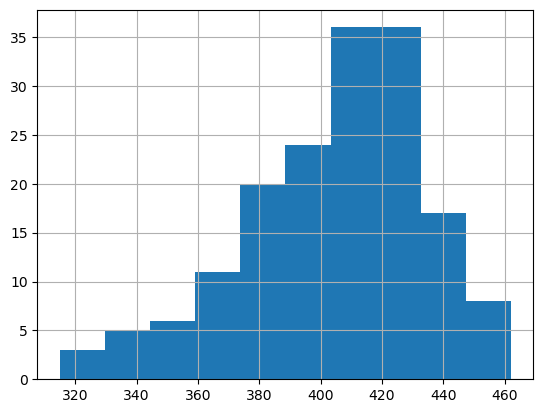

In [678]:
train['kcal'].hist()

In [680]:
from sklearn.impute import SimpleImputer
num_impute=SimpleImputer(strategy='median')
train['kcal']=num_impute.fit_transform(train[['kcal']])
print(train['kcal'].head())

0    408.5
1    408.5
2    408.5
3    408.5
4    408.5
Name: kcal, dtype: float64


## 3.2 質的データの欠損値補完

次に、質的データの欠損値を補完する。  
'payday'は 0/1 のフラグとして扱うため、欠損値を 0（給料日でない）とみなし、整数型に揃える。  
'event' および 'remarks' は欠損値を「なし」というカテゴリに統一し、情報の有無を明示的に表現する。

また、'precipitation' については、'--' が実質的に降水量 0 を意味しているため、文字列 '--' を '0' に置き換えたうえで float 型に変換し、  
後続の数値処理やスケーリングで扱いやすい形に整える。

In [682]:
train['payday'] = train['payday'].fillna(0).astype(int)
train['event'] = train['event'].fillna('なし')
train['remarks'] = train['remarks'].fillna('なし')
train['precipitation'] = (
    train['precipitation']
        .replace('--', '0')
        .astype(float)
)
print(train['remarks'].head())
print(train['event'].head())
print(train['payday'].head())
print(train['precipitation'].head())

0    なし
1    なし
2    なし
3    なし
4    なし
Name: remarks, dtype: object
0    なし
1    なし
2    なし
3    なし
4    なし
Name: event, dtype: object
0    0
1    0
2    0
3    0
4    0
Name: payday, dtype: int32
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: precipitation, dtype: float64


欠損値がなくなったことを確認する。

In [684]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       207 non-null    object 
 1   y              207 non-null    int64  
 2   week           207 non-null    object 
 3   soldout        207 non-null    int64  
 4   name           207 non-null    object 
 5   kcal           207 non-null    float64
 6   remarks        207 non-null    object 
 7   event          207 non-null    object 
 8   payday         207 non-null    int32  
 9   weather        207 non-null    object 
 10  precipitation  207 non-null    float64
 11  temperature    207 non-null    float64
dtypes: float64(3), int32(1), int64(2), object(6)
memory usage: 18.7+ KB


## 3.3 数値特徴量のスケーリング準備

まず、数値特徴量である 'kcal','precipitation','temperature' について、各種統計量を確認し、  
平均・標準偏差・最小値・最大値などのスケール感を把握する。  
この結果から、3 つの特徴量のスケールが大きく異なっていることが分かり、後続の学習に向けてスケーリングが必要であると判断する。

In [686]:
numerical_columns=['kcal','precipitation','temperature']
train[numerical_columns].describe()

,kcal,precipitation,temperature
count,207.000000,207.000000,207.000000
mean,405.219807,0.113527,19.252174
std,26.795726,0.659443,8.611365
min,315.000000,0.000000,1.200000
25%,395.500000,0.000000,11.550000
50%,408.500000,0.000000,19.800000
75%,422.000000,0.000000,26.100000
max,462.000000,6.500000,34.600000


## 4.1 量的特徴量の変換（対数変換・Box-Cox 変換・標準化）

量的特徴量に対しては、スケーリングの前に分布形状を確認し、必要に応じて分布の歪みを緩和する変換を行う。  
'kcal' はほぼ正規分布に近いが左側にやや裾が長く、'precipitation','temperature'についてもヒストグラムを確認すると、正規分布に近づける余地のあることが分かる。  

このため、3 つの特徴量に対して Box-Cox 変換を適用し、分布を正規分布に近づけることを試みる。  
'precipitation' は 0 を含むため、そのままでは Box-Cox 変換を適用できないことから、事前に '+0.01'のシフトを加えてから変換を行う。

Box-Cox 変換後の 'boxcox_columns.describe()' を確認すると、依然として 3 列のスケールが揃っていないことが分かるため、  
'StandardScaler' を用いて 3 列すべてを標準化し、平均 0・分散 1 のスケールに揃える。  
最後に、標準化後の値を元の 'train[numerical_columns' に上書きし、学習用の数値特徴量として利用できる状態にする。

<Axes: >

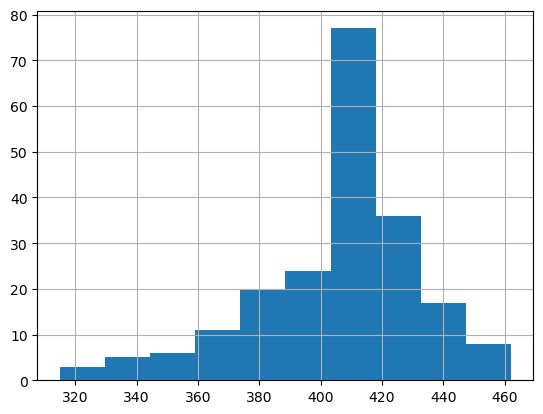

In [688]:
train['kcal'].hist()

<Axes: >

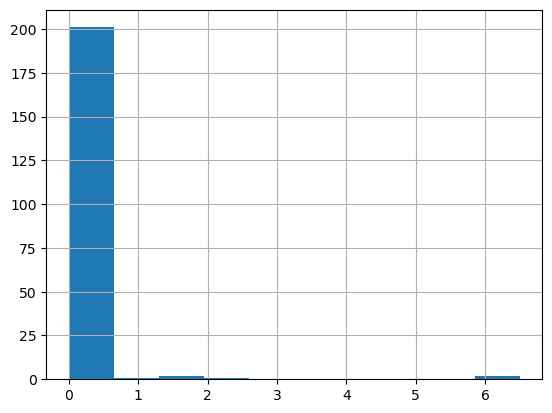

In [690]:
train['precipitation'].hist()

<Axes: >

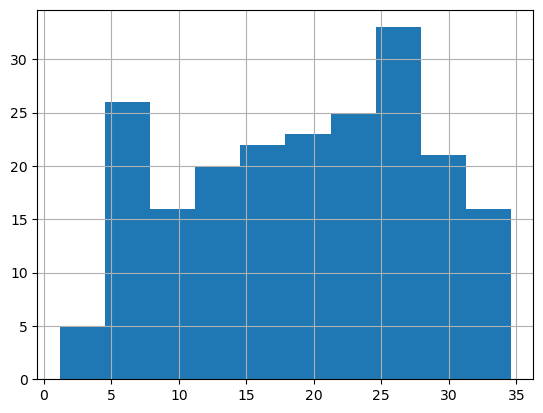

In [691]:
train['temperature'].hist()

In [693]:
train['precipitation']=train['precipitation']+0.01

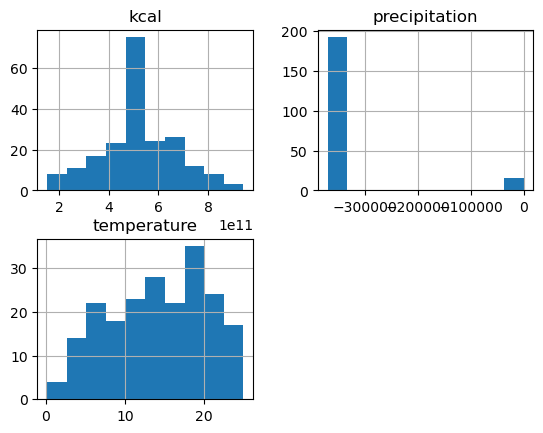

In [694]:
from sklearn.preprocessing import PowerTransformer
boxcox_transformer=PowerTransformer(method='box-cox',standardize=False)
boxcox_columns=pd.DataFrame(
    boxcox_transformer.fit_transform(train[numerical_columns]),
    columns=numerical_columns
)
boxcox_columns.hist()

# --- テストで実際に使う temperature 専用 ---
pt_temp = PowerTransformer(method='box-cox', standardize=False)
train_temp_boxcox = pt_temp.fit_transform(train[['temperature']])  # (n,1)

from sklearn.preprocessing import PowerTransformer, StandardScaler
scaler_temp = StandardScaler()
train_temp_scaled = scaler_temp.fit_transform(train_temp_boxcox)
train['temperature'] = train_temp_scaled


In [696]:
boxcox_columns.describe()

,kcal,precipitation,temperature
count,2.070000e+02,207.000000,207.000000
mean,5.242037e+11,-343234.987964,14.222711
std,1.494047e+11,96169.327470,6.242986
min,1.529061e+11,-370050.125671,0.197884
25%,4.504650e+11,-370050.125671,8.742278
50%,5.252150e+11,-370050.125671,14.788793
75%,6.129095e+11,-370050.125671,19.205825
max,9.420939e+11,0.329493,24.979450


In [698]:
from sklearn.preprocessing import StandardScaler
boxcox_std_columns=pd.DataFrame(
    StandardScaler().fit_transform(boxcox_columns),
    columns=numerical_columns
)
boxcox_std_columns.describe()

,kcal,precipitation,temperature
count,2.070000e+02,2.070000e+02,2.070000e+02
mean,-1.442754e-16,-1.171366e-15,-6.178632e-16
std,1.002424e+00,1.002424e+00,1.002424e+00
min,-2.491206e+00,-2.795085e-01,-2.251939e+00
25%,-4.947471e-01,-2.795085e-01,-8.799826e-01
50%,6.785250e-03,-2.795085e-01,9.089472e-02
75%,5.951674e-01,-2.795085e-01,8.001291e-01
max,2.803816e+00,3.577725e+00,1.727189e+00


array([[<Axes: title={'center': 'kcal'}>,
        <Axes: title={'center': 'precipitation'}>],
       [<Axes: title={'center': 'temperature'}>, <Axes: >]], dtype=object)

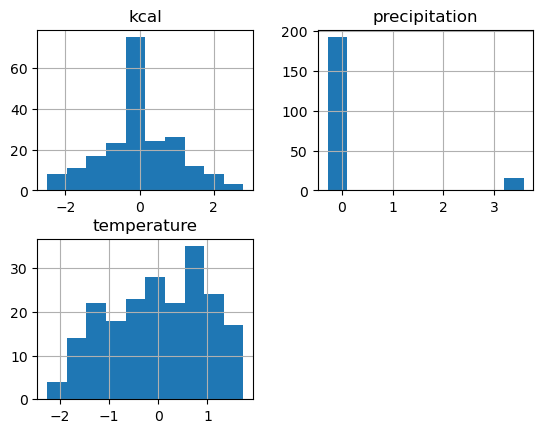

In [699]:
boxcox_std_columns.hist()

In [701]:
train[numerical_columns] = boxcox_std_columns
train[numerical_columns].head()

,kcal,precipitation,temperature
0,0.006785,-0.279508,0.090895
1,0.006785,-0.279508,-0.232234
2,0.006785,-0.279508,-0.407783
3,0.006785,-0.279508,-0.443119
4,0.006785,-0.279508,-0.337342


## 4.2 質的特徴量の変換・作成

まず、日付情報からより細かい特徴量を作成する。  
'datetime' 列を 'pd.to_datetime'で日付型に変換し、年・月・日に分解することで、  
季節性や月次・日次のパターンをモデルが捉えやすくする。

さらに、曜日を表す 'week' 列および天候を表す 'weather' 列については、  
'pd.get_dummies'を用いて One-Hot エンコーディングを行い、カテゴリ変数を 0/1 のダミー変数として扱えるようにする。

次に、メニュー内容に基づく需要の違いを特徴量として取り入れる。  
'remarks' 列に「お楽しみメニュー」と記載されている日の 'y' の平均値を算出すると、全体平均と比べて販売数が高い傾向があることが分かる。  
同様に、'name' 列に「カレー」を含むメニューの日についても 'y' の平均を比較し、カレーの日は需要が高くなる傾向を確認する。

この結果を踏まえ、次の 2 つのフラグ特徴量を作成する。  

- 'is_otanoshi': 'remarks' が「お楽しみメニュー」の場合に 1、それ以外は 0  
- 'is_curry': 'name' に「カレー」を含む場合に 1、それ以外は 0  

なお、「手作り」「カツ」など他の文字列についても同様の検討を行ったが、  
後続の評価（第 6 章）において RMSE の改善が見られなかったため、最終的な特徴量には採用していない。

In [703]:
train['datetime'] = pd.to_datetime(train['datetime'])
# 年・月・日
train['year']   = train['datetime'].dt.year
train['month']  = train['datetime'].dt.month
train['day']    = train['datetime'].dt.day
train = pd.get_dummies(
    train,
    columns=['week','weather'],
    dummy_na=False,
    dtype=int
)
train.head()

,datetime,y,soldout,name,kcal,remarks,event,payday,precipitation,temperature,...,week_水,week_火,week_金,weather_快晴,weather_晴れ,weather_曇,weather_薄曇,weather_雨,weather_雪,weather_雷電
0,2013-11-18,90,0,厚切りイカフライ,0.006785,なし,なし,0,-0.279508,0.090895,...,0,0,0,1,0,0,0,0,0,0
1,2013-11-19,101,1,手作りヒレカツ,0.006785,なし,なし,0,-0.279508,-0.232234,...,0,1,0,1,0,0,0,0,0,0
2,2013-11-20,118,0,白身魚唐揚げ野菜あん,0.006785,なし,なし,0,-0.279508,-0.407783,...,1,0,0,1,0,0,0,0,0,0
3,2013-11-21,120,1,若鶏ピリ辛焼,0.006785,なし,なし,0,-0.279508,-0.443119,...,0,0,0,1,0,0,0,0,0,0
4,2013-11-22,130,1,ビッグメンチカツ,0.006785,なし,なし,0,-0.279508,-0.337342,...,0,0,1,1,0,0,0,0,0,0


In [705]:
print(train['y'].mean())
mean_y = train.loc[train['remarks'] == 'お楽しみメニュー', 'y'].mean() #df.loc[行の指定, 列の指定]。 location-based indexer（ラベルに基づく位置指定）
print(mean_y)

# カレーを含むかどうかのフラグ列を一時的に作成
tmp = train.assign(
    is_curry=train["name"].str.contains("カレー", na=False)
)

# is_curry ごとの y の平均を計算
mean_y_by_curry = tmp.groupby("is_curry")["y"].mean()
# カレーを含む行だけの y 平均
mean_y_curry = mean_y_by_curry.loc[True]
print(mean_y_curry)

86.6231884057971
108.75
111.17647058823529


In [707]:
train['is_otanoshi'] = (train['remarks'] == 'お楽しみメニュー').astype(int) #True/False の Series（ブール配列）を作る。
train['is_curry'] = train['name'].str.contains('カレー', na=False).astype(int)

## 5. 特徴量選択

ここまでに作成した特徴量のうち、モデルに入力するものを選択する。  
訓練データを確認した結果、'soldout' は需要ではなく結果側の情報を含んでおり説明変数としては不適当なため除外する。  
'remarks' は「お楽しみメニュー」以外の情報はノイズが多いと判断し、'is_otanoshi' のみを利用する。  
'event' も今回のデータでは明確な効果が確認できなかったため、除外する。  

'name' はメニューの種類が多く、高次元なダミー変数となるため、リスクや解釈性を考慮し、  
「カレー」かどうかを表す 'is_curry' のみを採用し、その他の細かい種類は使用しない。最終的にベースとなる特徴量として次の列を採用する。  

- 年・月・日: 'year', 'month', 'day'  
- 気温: 'temperature'  
- メニュー関連フラグ: 'is_otanoshi', 'is_curry' 
- 曜日ダミー: 'week_' で始まる列（全て）

これらを組み合わせて 'X'（説明変数）を構成し、目的変数 'y' とともにモデル学習に用いる。

In [709]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model=LinearRegression()
base_cols = ['year', 'month', 'day','temperature','is_otanoshi','is_curry']

# 列名が week_ で始まるものを全部選ぶ
cols_regex = train.filter(regex=r'^week_').columns

X = train[base_cols + list(cols_regex)]
y = train['y']

## 6. モデル学習と評価（時系列クロスバリデーション）

特徴量エンジニアリングとモデル選択が妥当かどうかを検証するため、重回帰モデルで学習・評価を行う。  
データは時系列で並んでいるため、k-分割交差法ではなく 'TimeSeriesSplit' を用いた時系列クロスバリデーションを採用し、  
過去データで学習し、未来データで検証するという現実的な設定を再現する。

具体的には、'n_splits=5' の 'TimeSeriesSplit' で学習期間と検証期間を段階的にずらしながら 5 回の学習・予測を行い、  
各分割ごとに RMSE を算出してスコアの推移と平均値を確認する。  
この過程で、'base_cols' の候補を入れ替えながら複数の特徴量パターンを試し、  
最終的に 'year', 'month', 'day','temperature','is_otanoshi','is_curry' と 'week_' 系の特徴量を残した組み合わせが、  
RMSEの観点で最も安定して良好な性能を示したため、最終モデルの特徴量セットとして採用している。

In [711]:
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []

for i, (tr_idx, va_idx) in enumerate(tscv.split(X)):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)

    rmse = np.sqrt(mean_squared_error(y_va, y_pred))
    rmse_scores.append(rmse)
    print(f'fold {i}: RMSE={rmse:.3f}, n_train={len(tr_idx)}, n_val={len(va_idx)}')

print('RMSE (per fold):', rmse_scores)
print('RMSE mean:', np.mean(rmse_scores))

fold 0: RMSE=18.165, n_train=37, n_val=34
fold 1: RMSE=20.722, n_train=71, n_val=34
fold 2: RMSE=21.236, n_train=105, n_val=34
fold 3: RMSE=13.900, n_train=139, n_val=34
fold 4: RMSE=14.198, n_train=173, n_val=34
RMSE (per fold): [18.16457774883987, 20.721601168966618, 21.236498604944394, 13.900337049482815, 14.19827577936682]
RMSE mean: 17.644258070320106


## 7. テストデータへの適用と予測

学習時と同じ前処理・特徴量エンジニアリングをテストデータにも適用し、予測値を算出する。  
数値特徴量 'temperature' については、学習時の Box-Cox 変換および標準化の変換方法を再利用し、  
学習データと同じスケールに揃える。

日付情報については、'datetime' を日付型に変換したうえで年・月・日に分解し、  
学習時と同様に 'year', 'month', 'day' の 3 つの特徴量を作成する。  
曜日を表す 'week' 列に対しては、'pd.get_dummies' を用いて One-Hot エンコーディングを行い、'week_' で始まるダミー変数群を作る。

メニューに関連する特徴量も学習時と同じ方法で作成する。  

- 'is_otanoshi': 'remarks' が「お楽しみメニュー」の場合に 1、それ以外は 0  
- 'is_curry': 'name' に「カレー」を含む場合に 1、それ以外は 0  

これらの処理を通じて、学習時に使用した特徴量セット  
'year', 'month', 'day', 'temperature', 'is_otanoshi', 'is_curry' および 'week_' 系の列を揃え、  
'X_test' として学習済みモデル 'model' に渡し、テストデータの販売数予測 'y_pred_test' を得る。

In [713]:
test=pd.read_csv('test.csv')
#temperature
# test では temperature だけ変換したいので単一列に上書き
numerical_columns = ['temperature']

# Box-Cox と標準化は、学習時に fit 済みの transformer を再利用する
test_temp_boxcox = pt_temp.transform(test[numerical_columns])   
test_temp_scaled = scaler_temp.transform(test_temp_boxcox)

test['temperature'] = test_temp_scaled

#year,month,day
test['datetime'] = pd.to_datetime(test['datetime'])

test['year']   = test['datetime'].dt.year
test['month']  = test['datetime'].dt.month
test['day']    = test['datetime'].dt.day

#week_
test = pd.get_dummies(
    test,
    columns=['week'],
    dummy_na=False,
    dtype=int
)

#is_otanoshi
test['is_otanoshi'] = (test['remarks'] == 'お楽しみメニュー').astype(int)

#is_curry
test['is_curry'] = test['name'].str.contains('カレー', na=False).astype(int)


base_cols = ['year', 'month', 'day','temperature','is_otanoshi','is_curry']

# 列名が week_ で始まるものを全部取る
cols_regex = test.filter(regex=r'^week_').columns

X_test = test[base_cols + list(cols_regex)]
y_pred_test=model.predict(X_test)



## 8. 提出ファイル（CSV）の作成

最後に、予測結果を指定の形式に整えて CSV で出力する。  
テストデータの 'datetime' から年・月・日を取り出し、'YYYY-M-D' 形式の文字列に結合して提出用の 1 列目とする。  
2 列目には予測値 'y_pred_test' を配置し、インデックス・ヘッダー行なしで 'submission.csv' としてファイルを生成する。

In [715]:

# 年・月・日を取り出す
y = test['datetime'].dt.year
m = test['datetime'].dt.month
d = test['datetime'].dt.day

# 0埋めしない 'YYYY-M-D' 形式の文字列を作る
date_str = y.astype(str) + '-' + m.astype(str) + '-' + d.astype(str)

# 提出用 DataFrame（列名はダミーなので 0, 1 としておく）
submit = pd.DataFrame({
    0: date_str,      # 1列目: ハイフン区切り・0埋めなしの日付
    1: y_pred_test    # 2列目: 予測値
})

# ヘッダー行なし・インデックスなしで CSV 出力
submit.to_csv('submission.csv', index=False, header=False)